In [1]:
import scipy.io as sio
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import cmath
import matplotlib
import hubbard_1d
import quspin
import fejer_kernel
import fourier_filter
import generate_cdf
from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10


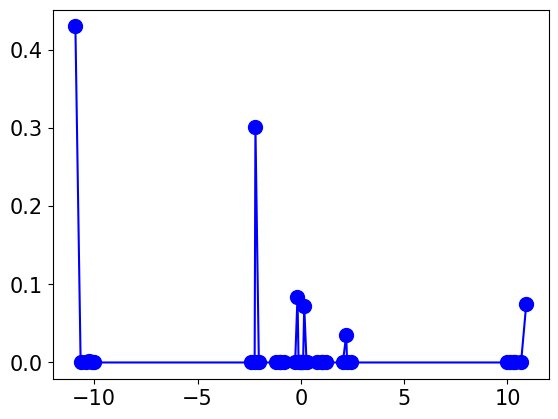

[4.29609394e-01 1.20370622e-31]


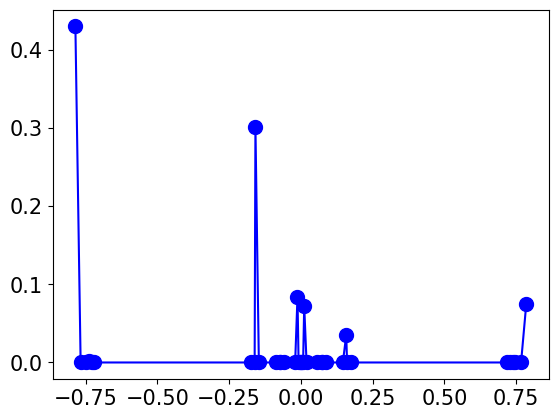

In [3]:
num_sites = 4
J = 1.0
U = 10.0
U0 = 0.0
mu = 0.0
N_up = num_sites // 2
N_down = num_sites - N_up

num_eigenstates_max = 100

ham0 = hubbard_1d.generate_ham(num_sites, J, U0, mu, N_up, N_down)
ground_state_0 = ham0.eigsh(k=1,which="SA")[1][:,0]

ham = hubbard_1d.generate_ham(num_sites, J, U, mu, N_up, N_down)
if( num_eigenstates_max > ham.shape[0] // 2):
    eigenenergies, eigenstates = ham.eigh()
else:
    eigenenergies, eigenstates = ham.eigsh(k=num_eigenstates_max,which="SA")
ground_state = eigenstates[:,0]

population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2

plt.plot(eigenenergies,population_raw,'b-o');plt.show()

spectrum, population = generate_spectrum_population(eigenenergies, population_raw, 
                                                    [population_raw[0],population_raw[1]])

plt.plot(spectrum, population,'b-o');plt.show()


In [ ]:
p0_array=np.array([0.4,0.1]) #overlap
p1_array=np.array([0.1,0.025]) #overlap
#relative population=0.8
T0 = 2000
N_test_QCELS = 10  #number of QCELS test
N_QPE = 10  #number of QPE test
T_list_QCELS = 150+T0/4*(np.arange(N_test_QCELS))
T_list_QPE = 150+T0*7.5*(np.arange(N_QPE))
err_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
cost_list_avg_QCELS = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QPE = np.zeros((len(p0_array),len(T_list_QPE)))
rate_success_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
rate_success_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
max_T_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
Navg = 10 #number of trying
err_thres_hold=0.01
err_thres_hold_QPE=0.01
#-----------------------------    
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    p1=p1_array[a1]
    n_success_QCELS= np.zeros(len(T_list_QCELS))
    n_success_QPE= np.zeros(len(T_list_QPE))
    for n_test in range(Navg):
        print("For p0=",p0,"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0,p1])
        #------------------QCELS-----------------
        # heuristic estimate of relative gap
        rel_gap_idx = np.where(population>p0/2)[0][1]
        rel_gap = spectrum[rel_gap_idx]-spectrum[0]
        d=int(20/rel_gap)
        print("d=", d, "rel_gap = ", rel_gap, "rel_overlap", p0/sum(population[0:(rel_gap_idx)]))
        Nsample_rough=int(500/p0**2*np.log(d))
        Nsample=int(30/p0**2*np.log(d))
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            NT = 5
            err_tol_rough=rel_gap/4
            ground_energy_estimate_QCELS, cost_list_avg_QCELS[a1,ix], max_T_QCELS[a1,ix] = \
                    qcels_smalloverlap(spectrum, population, T, NT, d, rel_gap, \
                                    err_tol_rough, Nsample_rough, Nsample)
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS - spectrum[0])
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS[ix]+=1

       # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0))
        for ix in range(len(T_list_QPE)):
            T = int(T_list_QPE[ix])
            discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi
            dist = generate_QPE_distribution(spectrum,population,2*T)
            samp = generate_cdf.draw_with_prob(dist,N_try_QPE)
            j_min = samp.min()
            ground_energy_estimate_QPE = discrete_energies[j_min]
            err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)
            if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg


For p0= 0.4 For N_test= 1
[0.4 0.1]
d= 31 rel_gap =  0.6271932206802948 rel_overlap 0.7970177089522112
For p0= 0.4 For N_test= 2
[0.4 0.1]
d= 31 rel_gap =  0.6271932206802948 rel_overlap 0.7970177089522112
For p0= 0.4 For N_test= 3
[0.4 0.1]
d= 31 rel_gap =  0.6271932206802948 rel_overlap 0.7970177089522112
For p0= 0.4 For N_test= 4
[0.4 0.1]
d= 31 rel_gap =  0.6271932206802948 rel_overlap 0.7970177089522112
For p0= 0.4 For N_test= 5
[0.4 0.1]
d= 31 rel_gap =  0.6271932206802948 rel_overlap 0.7970177089522112
For p0= 0.4 For N_test= 6
[0.4 0.1]
d= 31 rel_gap =  0.6271932206802948 rel_overlap 0.7970177089522112
For p0= 0.4 For N_test= 7
[0.4 0.1]
d= 31 rel_gap =  0.6271932206802948 rel_overlap 0.7970177089522112
For p0= 0.4 For N_test= 8
[0.4 0.1]
d= 31 rel_gap =  0.6271932206802948 rel_overlap 0.7970177089522112
For p0= 0.4 For N_test= 9
[0.4 0.1]
d= 31 rel_gap =  0.6271932206802948 rel_overlap 0.7970177089522112
For p0= 0.4 For N_test= 10
[0.4 0.1]
d= 31 rel_gap =  0.6271932206802948 

QCELS
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
QPE
[[0.  1.  0.9 0.9 1.  1.  1.  1.  1.  1. ]
 [0.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]]


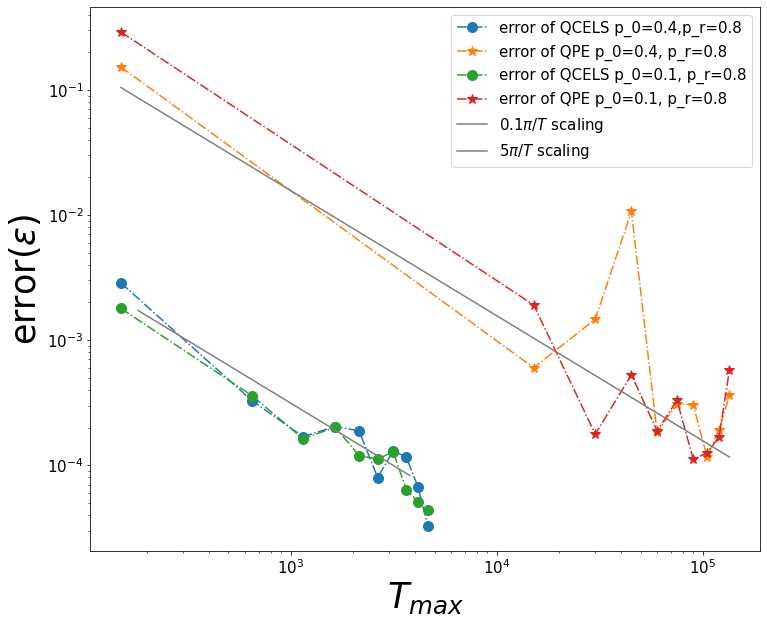

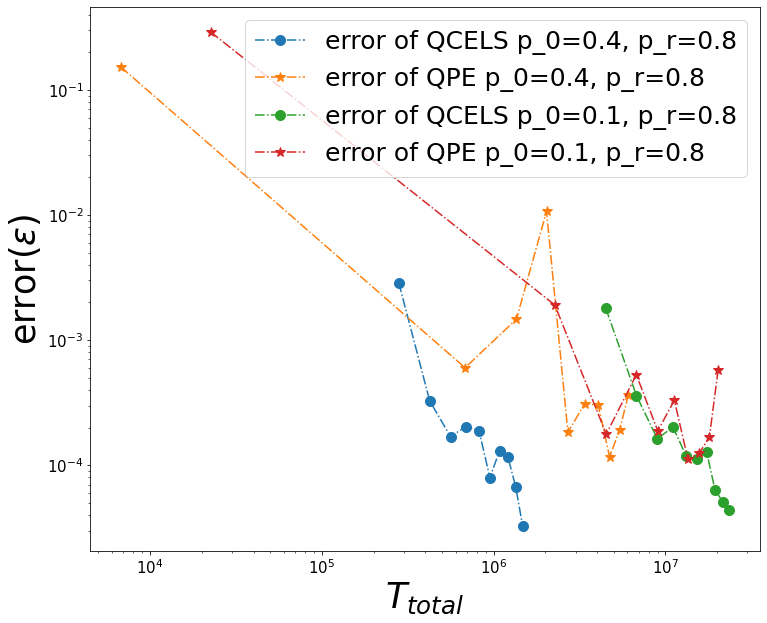

In [45]:
print('QCELS')
print(rate_success_QCELS)
print('QPE')
print(rate_success_QPE)    
plt.figure(figsize=(12,10))
plt.plot(T_list_QCELS,err_QCELS[0,:],linestyle="-.",marker="o",label="error of QCELS p_0=0.4,p_r=0.8")
plt.plot(T_list_QPE,err_QPE[0,:],linestyle="-.",marker="*",label="error of QPE p_0=0.4, p_r=0.8")
plt.plot(T_list_QCELS,err_QCELS[1,:],linestyle="-.",marker="o",label="error of QCELS p_0=0.1, p_r=0.8")
plt.plot(T_list_QPE,err_QPE[1,:],linestyle="-.",marker="*",label="error of QPE p_0=0.1, p_r=0.8")
plt.plot(max_T_QCELS[0,:],0.1*np.pi/max_T_QCELS[0,:],linestyle="-",color="grey",label="$0.1\pi/T$ scaling")
plt.plot(T_list_QPE,5*np.pi/T_list_QPE,linestyle="-",color="grey",label="$5\pi/T$ scaling")
plt.xlabel("$T_{max}$",fontsize=35)
plt.ylabel("error($\epsilon$)",fontsize=35)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig('Hubbard_depth_4.pdf')
plt.figure(figsize=(12,10))
plt.plot(cost_list_avg_QCELS[0,:],err_QCELS[0,:],linestyle="-.",marker="o",label="error of QCELS p_0=0.4, p_r=0.8")
plt.plot(cost_list_avg_QPE[0,:],err_QPE[0,:],linestyle="-.",marker="*",label="error of QPE p_0=0.4, p_r=0.8")
plt.plot(cost_list_avg_QCELS[1,:],err_QCELS[1,:],linestyle="-.",marker="o",label="error of QCELS p_0=0.1, p_r=0.8")
plt.plot(cost_list_avg_QPE[1,:],err_QPE[1,:],linestyle="-.",marker="*",label="error of QPE p_0=0.1, p_r=0.8")
plt.xlabel("$T_{total}$",fontsize=35)
plt.ylabel("error($\epsilon$)",fontsize=35) 
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=25)
plt.savefig('Hubbard_cost_4.pdf')
plt.show()